# The Gross-Pitaevskii equation (GPE) on a lattice
$$
i \frac{d\psi_j(t)}{dt} = -J[\psi_{j-1}(t) + \psi_{j+1}(t)] + V_j \psi_j(t) + g|\psi_j(t)|^2 \psi_j(t)
$$

In [1]:
from collections import namedtuple
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

System

In [2]:
quantum_system = namedtuple('quantum_system', ['J', 'g', 'V', 'ψ'])

Define the Hamiltonian function
$$
    H[\vec{\psi}] = -J\left[\psi_{j-1} + \psi_{j+1}\right] + \left(V_j + g|\psi_j|^2\right) \psi_j
$$

In [3]:
def Hamiltonian(t:float, ψ:np.ndarray, qsys:quantum_system):
    
    J = qsys.J
    
    Hψ = np.zeros_like(ψ)
    
    Hψ[1:-1] = -J * (ψ[:-2] + ψ[2:])
    
    # imposing boundary conditions 
    Hψ[0] = -J * (ψ[-1] + ψ[1])
    Hψ[-1] = -J * (ψ[-2] + ψ[0])
    
    Hψ += (qsys.V + qsys.g * np.abs(ψ) ** 2) * ψ
    
    return Hψ

Imaginary time propagator to find the ground state
$$
    \frac{d\vec{\psi}(\tau)}{d\tau} = -H[\vec{\psi}(\tau)].
$$

In [4]:
def img_propagator(τ:float, n:int, qsys:quantum_system):

    times, dtimes = np.linspace(0, τ, n + 1, retstep=True)
    
    solver = ode(
        lambda τ, ψ: -Hamiltonian(τ, ψ, qsys)
    ).set_integrator('zvode')
    
    ψ = np.copy(qsys.ψ)
    
    for t in times[1:-1]:
        solver.set_initial_value(ψ, t)
        ψ = solver.integrate(t + dtimes)
        ψ /= np.linalg.norm(ψ)

    # update the wavefunction of the system
    qsys.ψ[:] = ψ

Real time propagation
$$
    \frac{d\vec{\psi}(t)}{dt} = -i H[\vec{\psi}(t)].
$$

In [5]:
def propagator(times:np.ndarray, qsys:quantum_system):
        
    solver = ode(
        lambda t, ψ: -1j * Hamiltonian(t, ψ, qsys)
    ).set_integrator('zvode')
    
    solver.set_initial_value(qsys.ψ, times[0])
    
    wavefunctions = [qsys.ψ.copy(),]
    wavefunctions.extend(
        solver.integrate(t) for t in times[1:]
    )
    
    qsys.ψ[:] = wavefunctions[-1]
    
    return np.array(wavefunctions)

## Testing

example of quantum systems

In [6]:
qsys = quantum_system(
    J = 1, 
    g = 1,

    # barrier 
    V = np.zeros(4),
    
    # the wavefunction
    ψ = np.ones(4, dtype=complex),
)

In [7]:
img_propagator(1, 100, qsys)

In [8]:
qsys

quantum_system(J=1, g=1, V=array([0., 0., 0., 0.]), ψ=array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]))

In [9]:
times = np.linspace(0, 2, 1000)
wavefunctions = propagator(times, qsys)

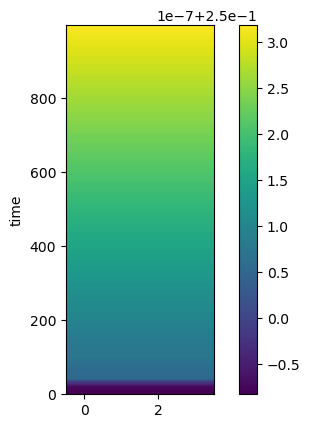

In [10]:
plt.imshow(
    np.abs(wavefunctions) ** 2,
    aspect=0.01,
    interpolation='nearest',
    origin='lower'
)

plt.ylabel("time")
plt.colorbar()
plt.show()

## Testing symmetric  tunneling with no self-interactions

In [11]:
tooth_saw_barrier = np.array([0, 1, 0.5, 0])

ψ0 = np.zeros(tooth_saw_barrier.size, dtype=complex)
ψ0[0] = 1
ψ0 /= np.linalg.norm(ψ0)

qsys_left = quantum_system(
    J = 1, 
    g = 0,

    # barrier 
    V = tooth_saw_barrier,
    
    # the wavefunction
    ψ = ψ0.copy(),
)

qsys_right = quantum_system(
    J = 1, 
    g = 0,

    # barrier 
    V = tooth_saw_barrier[::-1],
    
    # the wavefunction
    ψ = ψ0.copy(),
)

times = np.linspace(0, 6, 1000)

wavefunctions_left = propagator(times, qsys_left)
wavefunctions_right = propagator(times, qsys_right)

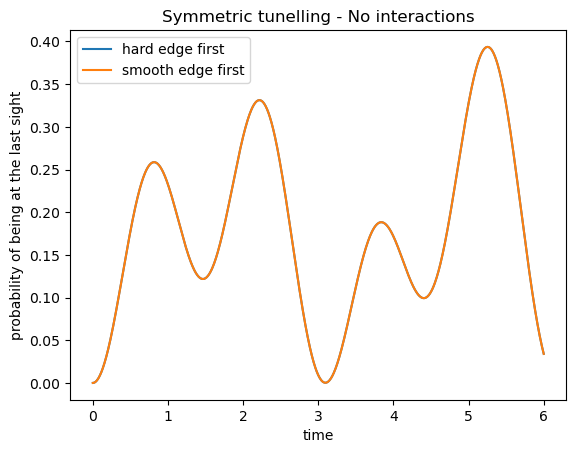

In [12]:
plt.title("Symmetric tunelling - No interactions")
plt.plot(times, np.abs(wavefunctions_left[:, -1]) ** 2, label="hard edge first")
plt.plot(times, np.abs(wavefunctions_right[:, -1]) ** 2, label="smooth edge first")
plt.xlabel("time")
plt.ylabel("probability of being at the last sight")
plt.legend()
plt.show()

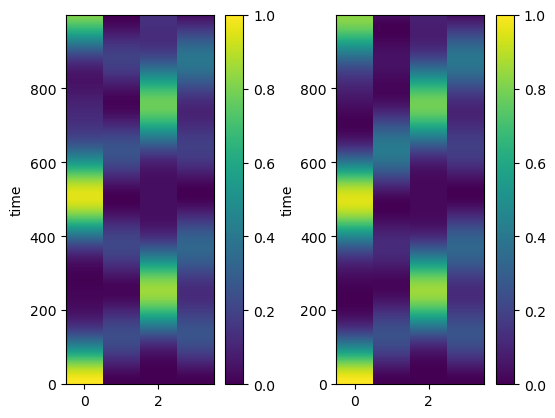

In [13]:
plt.subplot(121)

plt.imshow(
    np.abs(wavefunctions_left) ** 2,
    aspect=0.01,
    interpolation='nearest',
    origin='lower'
)

plt.ylabel("time")
plt.colorbar()

plt.subplot(122)

plt.imshow(
    np.abs(wavefunctions_right) ** 2,
    aspect=0.01,
    interpolation='nearest',
    origin='lower'
)

plt.ylabel("time")
plt.colorbar()
plt.show()

## Testing asymmetric  tunneling with interaction

In [14]:
tooth_saw_barrier = np.array([0, 1, 0.5, 0])

ψ0 = np.zeros(tooth_saw_barrier.size, dtype=complex)
ψ0[0] = 1
ψ0 /= np.linalg.norm(ψ0)

qsys_left = quantum_system(
    J = 1, 
    g = 1,

    # barrier 
    V = tooth_saw_barrier,
    
    # the wavefunction
    ψ = ψ0.copy(),
)

qsys_right = quantum_system(
    J = 1, 
    g = 1,

    # barrier 
    V = tooth_saw_barrier[::-1],
    
    # the wavefunction
    ψ = ψ0.copy(),
)

times = np.linspace(0, 6, 1000)

wavefunctions_left = propagator(times, qsys_left)
wavefunctions_right = propagator(times, qsys_right)

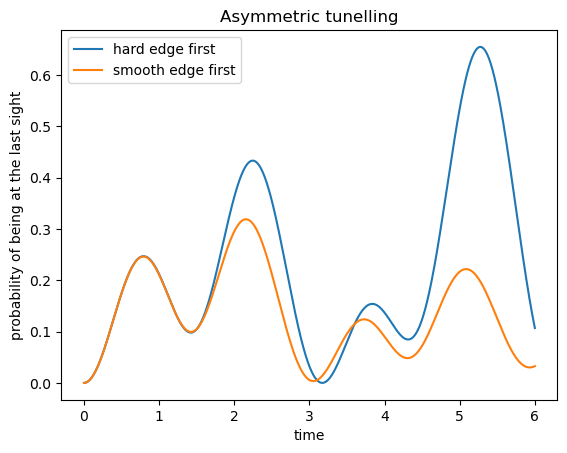

In [15]:
plt.title("Asymmetric tunelling")
plt.plot(times, np.abs(wavefunctions_left[:, -1]) ** 2, label="hard edge first")
plt.plot(times, np.abs(wavefunctions_right[:, -1]) ** 2, label="smooth edge first")
plt.xlabel("time")
plt.ylabel("probability of being at the last sight")
plt.legend()
plt.show()

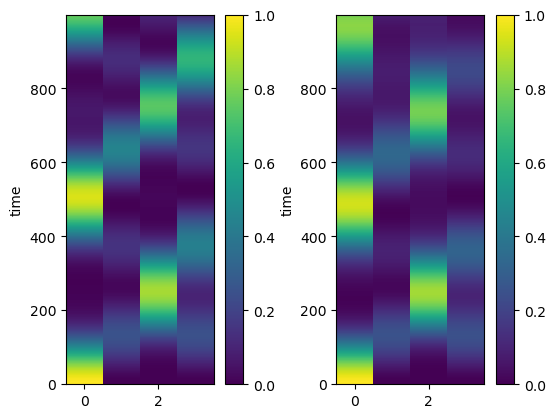

In [16]:
plt.subplot(121)

plt.imshow(
    np.abs(wavefunctions_left) ** 2,
    aspect=0.01,
    interpolation='nearest',
    origin='lower'
)

plt.ylabel("time")
plt.colorbar()

plt.subplot(122)

plt.imshow(
    np.abs(wavefunctions_right) ** 2,
    aspect=0.01,
    interpolation='nearest',
    origin='lower'
)

plt.ylabel("time")
plt.colorbar()
plt.show()